In [36]:
from typing import Annotated
from typing_extensions import TypedDict

In [37]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool  = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [38]:
wiki_tool.invoke('Who is Sharukh khan?')

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [39]:
arxiv_tool.invoke('Attention is all you need?')

'Published: 2024-04-03\nTitle: Positioning is All You Need\nAuthors: Xin Li\nSummary: One can drive safely with a GPS without memorizing a world map (not to\nmention the dark regions that humans have never explored). Such a\nlocality-based attention mechanism has a profound implication on our\nunderstandin'

In [40]:
tools=[wiki_tool,arxiv_tool]

In [41]:
## Langraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [42]:
from langgraph.graph import StateGraph,START,END


In [43]:
graphbuilder = StateGraph(State)

In [44]:
from langchain_groq import ChatGroq
from pathlib import Path
import os
from dotenv import load_dotenv
env_path = Path(r"D:\Anaconda\envs\langgraph_chatbot\.env")
load_dotenv(dotenv_path=env_path)

groq_api_key = os.getenv("GROQ_API_KEY")

## load llm model 

llm = ChatGroq(groq_api_key=groq_api_key,model='Gemma2-9b-It')
llm_with_tools=llm.bind_tools(tools=tools)

In [45]:
def chatbot(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}



In [46]:
from langgraph.prebuilt import ToolNode,tools_condition

In [47]:
graphbuilder.add_node('chatbot',chatbot)
graphbuilder.add_edge(START,"chatbot")
tool_node = ToolNode(tools=tools)
graphbuilder.add_node("tools",tool_node)

graphbuilder.add_conditional_edges(
    "chatbot",
    tools_condition  ##bidirectional edges
)
graphbuilder.add_edge("tools","chatbot")
graphbuilder.add_edge("chatbot",END)


In [48]:
graph = graphbuilder.compile()

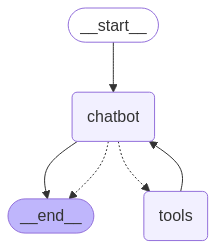

In [49]:
graph

In [51]:
user_input = "Hi there! My name is Anurag"

events=graph.stream(
    {'messages':[("user",user_input)]},stream_mode='values'
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Anurag
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_5qy2)
 Call ID: call_5qy2
  Args:
    query: Anurag
================================= Tool Message =================================
Name: wikipedia

Page: Anurag
Summary: Anurag (Devanagari: अनुराग) (pronounced "Anurāg"), sometimes shorted Anu, is a common Indian first name. There are various meanings of Anurag in Sanskrit such as attachment, devotion, passion and eternal love.
Notable people named Anurag include:

Anurag Basu, Bollywood film di
================================== Ai Message ==================================

Anurag is a common Indian first name.  There are various meanings of Anurag in Sanskrit such as attachment, devotion, passion and eternal love.
